# Tutorial 2 - The Queens & The Art of Branching

**Important:** You must fully complete Tutorial $i-1$ before starting Tutorial $i$ ($i>1$).

Constraint programming is used to solve highly combinatorial and complex problems. 
In order to master CP, you need to get used to the philosophy behind this approach as well as the different 
techniques used along with it. We will guide you in this process step by step in the upcoming tutorials. We will be using "toy" puzzles/problems only for the purpose of learning different faces of CP. In real life problems, things get messed up easily and require decision and policy makes to agree opon the problem at hand.. (Trust us, we've been there..) 

In this tutorial, we use the N-Queens problem, one of oldest and classical problems solved efficiently by CP, as a case study. 

In [9]:
from config import setup
setup()

## 1. The N-Queens problem

You are given an N-by-N chessboard, and your goal is to place N chess queens on it so that no two queens threaten each other:

<div class="row" style="margin-top: 10px">
    <div class="col-md-5">
        <img src="display/images/empty-chessboard.png" style="margin-right: 0; width: 160px;" />
    </div>
    <div class="col-md-2" style="display: table">
        <i class="fa fa-arrow-right" style="display: table-cell; font-size: 50px; 
        margin: auto; text-align: center; vertical-align: middle; height: 150px"></i>
    </div>
    <div class="col-md-5">
        <img src="display/images/nqueens8-chessboard.png" style="margin-left: 0; width: 160px;" />
    </div>
</div>

Formally, a solution to the N-queens problem requires that no two queens share the same row, column or diagnoal.

### 1.1. Model without global constraints

**Exercice**: Create a function `decomposition_model(N)` that models the problem using only binary inequality constrants (no global constraint) and returns an instance of `CpoModel` for the n-queens problem with `N` queens.

In [3]:
def model_decomposition(n):
    mdl = CpoModel()
    v = mdl.integer_var_list(n, 0, n-1, 'x')
    for i in range(n):
        for j in range(n):
            if i != j:
                mdl.add(v[i]!=v[j])
                mdl.add(v[j]-v[i] != j-i)
                mdl.add(v[j]-v[i] != i-j)
    return mdl

**Exercice:** Test your function by solving the n-queens problem for small values of $N$ ($N < 20$).

<div class="alert alert-block alert-info">
    
Use the `display.n_queens` function in order to display a solution for the n-queens problem. This function can take a list of `int` corresponding to the column of the queens in order to display them.
    
</div>

 ! --------------------------------------------------- CP Optimizer 22.1.0.0 --
 ! Satisfiability problem - 7 variables, 126 constraints
 ! Presolve             = Off
 ! Workers              = 1
 ! SearchType           = DepthFirst
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 19.7 (before), 19.7 (after)
 !  . Memory usage      : 299.2 kB (before), 299.2 kB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !               Branches  Non-fixed            Branch decision
 *                      4  0.01s                  5  = x_4
 ! ----------------------------------------------------------------------------
 ! Search completed, 1 solution found.
 ! ----------------------------------------------------------------------------
 ! Number of branches     : 4
 ! Number of fails        : 0
 ! Total memory usage     : 645.4 kB (605.4 kB CP Optimizer + 40.0 kB Concert)
 ! Time spen

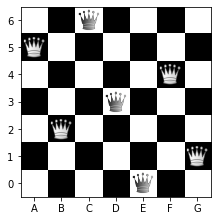

In [18]:
from docplex.cp.model import *
import display
n=7
mdl = model_decomposition(n)
sol = mdl.solve()
q = [sol.get_value(f"x_{i}") for i in range(n)]
display.n_queens(q)

**Question**: How many solutions are there for $N = 3,~\ldots,~10$? 

**Note:** To answer this question, you must force the solver to use a depth first strategy using  `CpoModel.start_search(SearchType="DepthFirst")`.

In [13]:
for n in range(3,11):
    mdl = model_decomposition(n)
    sol = mdl.start_search(LogVerbosity = 'Quiet')
    i = 0
    for s in sol:
        i += 1
    print("n : ",n," solutions : ",i)

n :  3  solutions :  0
n :  4  solutions :  2
n :  5  solutions :  10
n :  6  solutions :  4
n :  7  solutions :  40
n :  8  solutions :  92
n :  9  solutions :  352
n :  10  solutions :  724


### 1.2. Model with global constraints

**Exercice:** Create a function `global_constraint_model(N)` that models and returns an instance of `CpoModel` for the n-queens problem with `N` queens, using **only** and exaclty 3 global constraints.

In [14]:
def global_contraint_model(n):
    mdl = CpoModel()
    v = mdl.integer_var_list(n, 0, n-1, 'x')
    mdl.add(all_diff(v))
    mdl.add(all_diff(v[i] + i for i in range(n)))
    mdl.add(all_diff(v[i] - i for i in range(n)))
    return mdl

**Exercice:** Test your function by solving the n-queens problem for small values of $N$ ($N < 20$).

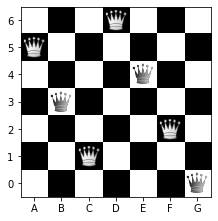

In [17]:
n = 7
mdl = global_contraint_model(n)
sol = mdl.solve(LogVerbosity = 'Quiet')
q = [sol.get_value(f"x_{i}") for i in range(n)]
display.n_queens(q)

**Question**: How many solutions are there for $N = 3,~\ldots,~10$?

**Important:** You should obtain the same number as the previous model!

In [19]:
for n in range(3,11):
    mdl = global_contraint_model(n)
    sol = mdl.start_search(LogVerbosity = 'Quiet')
    i = 0
    for s in sol:
        i += 1
    print("n : ",n," solutions : ",i)

n :  3  solutions :  0
n :  4  solutions :  2
n :  5  solutions :  10
n :  6  solutions :  4
n :  7  solutions :  40
n :  8  solutions :  92
n :  9  solutions :  352
n :  10  solutions :  724


## 2. Comparison of the two models

We will compare the two models properly. 

**Exercice:** Consider the `run(model, params)` function that we used in the first tutorial and paste it here.

In [20]:
def run(model, params):
    sol = model.solve(
        TimeLimit = params.TimeLimit, 
        LogVerbosity = params.LogVerbosity,
        LogPeriod = params.LogPeriod,
    )
    return (sol.get_infos()["NumberOfChoicePoints"],
            sol.get_infos()["TotalTime"],
            sol.get_infos()["SearchStatus"])

### 2.1. Basic comparison

To compare the two models, we will fix the time limit to 5 seconds, i.e. `TimeLimit=5`, while keeping all the other parameters to their default values.

**Exercice:** Compare the two models for $N \in \{200, 400, 600, .., 2000 \}$. 

<div class="alert alert-block alert-info">
    
By *comparing* we mean plotting the runtime **and** the number of decisions made by the solver for each model as a function of $n$
    
</div>

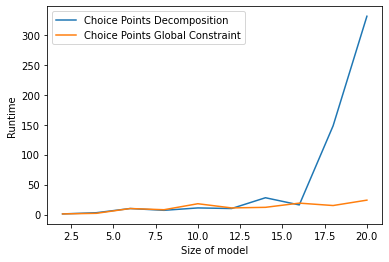

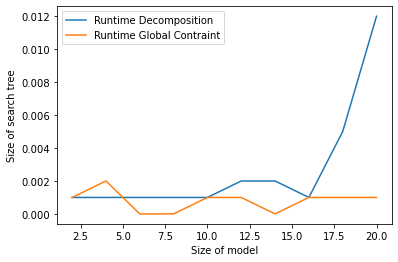

In [28]:
from docplex.cp.parameters import CpoParameters
import matplotlib.pyplot as plt

params = CpoParameters(TimeLimit = 5, LogVerbosity = 'Quiet')
n_list = list(range(2, 21, 2)) #promotional version limited
res = []
res_global_constraint = []
for i in n_list:
    res.append(run(model_decomposition(i), params))
    res_global_constraint.append(run(global_contraint_model(i), params))
    
    
#Choice of points
plt.xlabel("Size of model")
plt.ylabel("Runtime")
plt.plot(n_list,[i[0] for i in res], label='Choice Points Decomposition')
plt.plot(n_list,[i[0] for i in res_global_constraint], label='Choice Points Global Constraint')
plt.legend()
plt.show()

#Runtime
plt.xlabel("Size of model")
plt.ylabel("Size of search tree")
plt.plot(n_list,[i[1] for i in res], label='Runtime Decomposition')
plt.plot(n_list,[i[1] for i in res_global_constraint], label='Runtime Global Contraint')
plt.legend()
plt.show()

**Question:** What do you observe? Why? 

### 2.2. Branching strategies


**Important:** Before you start this part, please ask one of your supervisors to check on your work.

A CP solver is, at the end of the day, a backtracking solver. At each node, it applies filtering (called also propagation or pruning), then make a decision about the next node to explore. This decision is a pure heuristic choice, that is, it could be a wrong decision, it is only based on intuition. 

In CP, a decision is, most of the times, of the type: choose an unassigned variable $x$, choose a value $v$ from the current domain of $x$, and assign $v$ to $x$. These steps require a variable heuristic and a value heuristic. This is what we call branching strategy. 

Branching strategies can be generic (strategies that can be used for any problem), or specific (designed for the problem at hand). In CPOptimizer, there are a number of genereic strategies offered. This concerns both variable and value heuristics. 

For example, if $L$ is the list of decision variables, then by declaring a search_phase as follows: 

```python
SearchPhase= model.search_phase(L, 
                                varchooser=model.select_smallest(model.domain_size()),
                                valuechooser=model.select_random_value())

model.add_search_phase(SearchPhase)
```

The variable heuristic here is the one that picks the variable $x$ with the smallest domain size, and assigns a random value from its domain to it. 


Read about the different search strategies here: 
http://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#search-phases


We want to evaluate different strategies: 
- For variable evaluators, we will use 
 - `domain_size()`
 - `var_impact()`
 - `var_local_impact()`
 - `var_index()`
 
- For value evaluators, we will use 
 - `value_impact()`
 - `value_index()`
 
As for the selectors we will use : 
- `select_smallest()` 
- `select_largest()`

**Question:** How many strategies are we going to evaluate? 

**Question:** In addition to the above strategies, we will use also a pure random selection for variables and values. How can we use such a branching heuristic? 

Using the global constraints model, run the different strategies (**all of them, and pure random**) for different values of $N$. Make sure you choose a good value of $N$ that can assess your claims of evaluation. Feel free to use any reasnable time limit. 

<div class="alert alert-block alert-danger">

**Important:** For this exercice, you must set the `SearchType` to `DepthFirst` using `SearchType="DepthFirst"` when calling `run`.

We will investigate deeply this choice in the next tutorial. But at this stage you should trust us and include it in the solver's parameters.
    
</div>

**Exercice:** Present the results (rutime + number of nodes) via a table first then using plots. 

# Plots

# Compare value chooser

## var chooser = select smallest

## varchooser = select largest

# Compare var chooser

## Value chooser = smallest value impact

## Value chooser = smallest value index

## Value chooser = largest value impact

## Value chooser = larget value index

## Random select

**Question:** Is this what you expect? Is the choice of the branching strategy important? Justify.

On attendait plus de variations et moins de timeout : presque toutes les stratégies ont un timeout après n=50

**Question:** What is more important, the variable ordering or the value ordering choice? Justify.

Pour un value chooser donné, le choix du var chooser impacte plus les résultats. Alors que sur les plots on remarque que pour un var chooser donné, le value chooser ne change rien aux résultats.

**Question:** What is the best variable ordering choice? Justify.

Le meilleur semble être le smallest domain size : il a le moins de timeout, le moins de noeuds, et le plus de solutions feasible (les autres ont trop de unknown)

**Question:** What is the best value ordering choice? Justify.

Pas de différences observées

**Question:** What is a good branching overall? Any thoughts why this is the case? Justify.

Le random est étonnement plutôt bon dans notre cas

**Question:** Did you observe an opposite behaviour of heuristics betwen the runtime and the number of nodes? 
For instance, is there a strategy that is faster than others to solve the problem but requires a larger number of nodes? 
And conversely, is there a heuristic that is slow to solve the problem than others but uses less nodes? 
If you observe this, why is this happening?

## 3. Conclusion

**Question:** What did you learn today? 

<div class="alert alert-block alert-danger"></div>